# 카트폴 게임 마스터하기

In [19]:
import gym # 카트폴같은 여러 게임 환경 제공 패키지
# pip install gym 으로 설치 가능#
import random # 에이전트가 무작위로 행동할 확률을 구하기 위함.
import math # 에이전트가 무작위로 행동할 확률을 구하기 위함.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
#Deque : 먼저 들어온 데이터가 먼저 나가는 FIFO 자료구조의 일종으로 double-ended queue의 약자로, 일반적인 큐와 달리 양쪽 끝에서 삽입,삭제가 모두 가능한 자료구조다.
import matplotlib.pyplot as plt
# 필수 모듈 임포트하기

### 하이퍼파라미터



In [20]:
# 하이퍼파라미터 정의
EPISODES = 50    # 애피소드(총 플레이할 게임 수) 반복횟수
EPS_START = 0.9  # 학습 시작시 에이전트가 무작위로 행동할 확률
# ex) 0.5면 50% 절반의 확률로 무작위 행동, 나머지 절반은 학습된 방향으로 행동
# random하게 EPisolon을 두는 이유는 Agent가 가능한 모든 행동을 경험하기 위함.
EPS_END = 0.05   # 학습 막바지에 에이전트가 무작위로 행동할 확률
#EPS_START에서 END까지 점진적으로 감소시켜줌.
# --> 초반에는 경험을 많이 쌓게 하고, 점차 학습하면서 똑똑해지니깐 학습한대로 진행하게끔
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수 : 에이전트가 현재 reward를 미래 reward보다 얼마나 더 가치있게 여기는지에 대한 값.
# 일종의 할인율
LR = 0.001       # 학습률
BATCH_SIZE = 64  # 배치 크기

##DQN Agent 네트워크


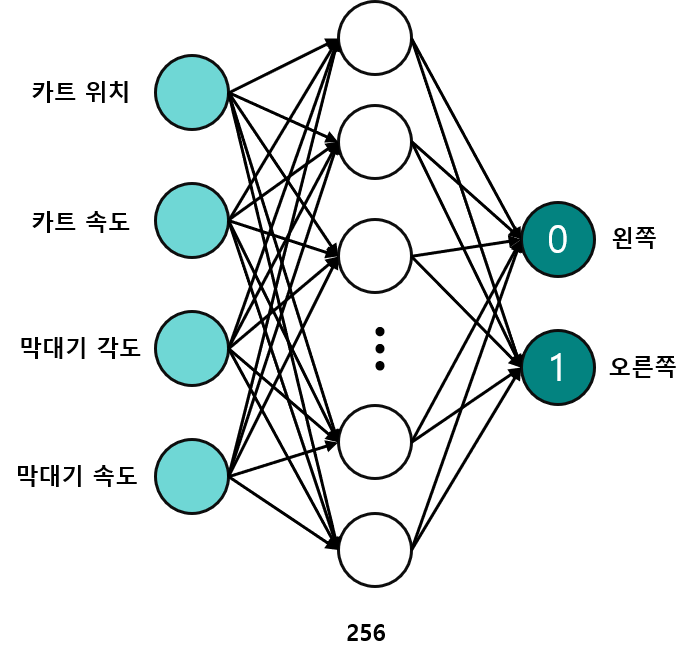

## DQN 에이전트

In [21]:
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(12, 1024),#신경망은 카트 위치, 카트 속도, 막대기 각도, 막대기 속도까지 4가지 정보를 입력
            nn.ReLU(),
            nn.Linear(1024, 1024),#신경망은 카트 위치, 카트 속도, 막대기 각도, 막대기 속도까지 4가지 정보를 입력
            nn.ReLU(),
            nn.Linear(1024, 1024),#신경망은 카트 위치, 카트 속도, 막대기 각도, 막대기 속도까지 4가지 정보를 입력
            nn.ReLU(),
            nn.Linear(1024, 2)#왼쪽으로 갈 때의 가치와 오른쪽으로 갈 때의 가치
        )
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0 #self.steps_done은 학습을 반복할 때마다 증가
        self.memory = deque(maxlen=10000)#memory에 deque사용.(큐가 가득 차면 제일 오래된것부터 삭제)

    def memorize(self, state, action, reward, next_state, prev_state1,  prev_state2):#에피소드 저장 함수
        # self.memory = [(상태, 행동, 보상, 다음 상태)...]
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state]),
                           prev_state1, 
                           prev_state2))
    
    def act(self, prev_state2, prev_state1, state):#행동 선택(담당)함수
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        #무작위 숫자와 엡실론을 비교

        # 엡실론 그리디(Epsilon-Greedy) 
        # : 초기엔 엡실론을 높게=최대한 경험을 많이 하도록 / 엡실론을 낮게 낮춰가며 = 신경망이 선택하는 비율 상승
        # if prev_state == None:
        #     return torch.LongTensor([[random.randrange(2)]])
        
        model_input = torch.cat((prev_state2, prev_state1, state), -1)
        if random.random() > eps_threshold:# 무작위 값 > 앱실론값 : 학습된 신경망이 옳다고 생각하는 쪽으로,
            return self.model(model_input).data.max(1)[1].view(1, 1)
        else:# 무작위 값 < 앱실론값 : 무작위로 행동
            return torch.LongTensor([[random.randrange(2)]])
    
    def learn(self):#메모리에 쌓아둔 경험들을 재학습(replay)하며, 학습하는 함수
        if len(self.memory) < BATCH_SIZE:# 메모리에 저장된 에피소드가 batch 크기보다 작으면 그냥 학습을 거름.
            return
        #경험이 충분히 쌓일 때부터 학습 진행
        batch = random.sample(self.memory, BATCH_SIZE) # 메모리에서 무작위로 Batch 크기만큼 가져와서 학습
        states, actions, rewards, next_states, prev_state1, prev_state2 = zip(*batch) #기존의 batch를 요소별 리스트로 분리해줄 수 있게끔

        #리스트를 Tensor형태로
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)
        prev_state1s = torch.cat(prev_state1)
        prev_state2s = torch.cat(prev_state2)

        # 모델의 입력으로 states를 제공, 현 상태에서 했던 행동의 가치(Q값)을 current_q로 모음
        model_input = torch.cat((prev_state2s, prev_state1s, states), -1)
        current_q = self.model(model_input).gather(1, actions)
        
        model_input = torch.cat((prev_state1s, states, next_states), -1)
        max_next_q = self.model(model_input).detach().max(1)[0]#에이전트가 보는 행동의 미래 가치(max_next_q)
        expected_q = rewards + (GAMMA * max_next_q)# rewards(보상)+미래가치
        
        # 행동은 expected_q를 따라가게끔, MSE_loss로 오차 계산, 역전파, 신경망 학습
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## 학습 준비하기

`gym`을 이용하여 `CartPole-v0`환경을 준비하고 앞서 만들어둔 DQNAgent를 agent로 인스턴스화 합니다.

자, 이제 `agent` 객체를 이용하여 `CartPole-v0` 환경과 상호작용을 통해 게임을 배우도록 하겠습니다.

In [22]:
env = gym.make('CartPole-v0')# env : 게임 환경 / 원하는 게임을 make함수에 넣어주면 됨.
agent = DQNAgent()
score_history = [] #점수 저장용

## 학습 시작

In [23]:
for e in range(1, EPISODES+1):#50번의 플레이(EPISODE수 만큼)
    state = env.reset()[0] # 매 시작마다 환경 초기화
    prev_state1 = torch.FloatTensor([state])
    prev_state2 = torch.FloatTensor([state])
    steps = 0
    while True: # 게임이 끝날때까지 무한루프
        env.render()
        state = torch.FloatTensor([state]) # 현 상태를 Tensor화

        # 에이전트의 act 함수의 입력으로 state 제공
        # Epsilon Greedy에 따라 행동 선택
        action = agent.act(prev_state2, prev_state1, state)
        
        # action : tensor, item 함수로 에이전트가 수행한 행동의 번호 추출
        # step함수의 입력에 제공 ==> 다음 상태, reward, 종료 여부(done, Boolean Value) 출력
        next_state, reward, done, _, _ = env.step(action.item())

        # 게임이 끝났을 경우 마이너스 보상주기
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state, prev_state1, prev_state2) # 경험(에피소드) 기억
        agent.learn()

        prev_state2 = prev_state1
        prev_state1 = state
        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps) #score history에 점수 저장
            break

에피소드:1 점수: 18
에피소드:2 점수: 20
에피소드:3 점수: 12
에피소드:4 점수: 12


에피소드:5 점수: 30
에피소드:6 점수: 70
에피소드:7 점수: 54
에피소드:8 점수: 29
에피소드:9 점수: 49
에피소드:10 점수: 142
에피소드:11 점수: 81
에피소드:12 점수: 442
에피소드:13 점수: 114
에피소드:14 점수: 156
에피소드:15 점수: 129
에피소드:16 점수: 64
에피소드:17 점수: 93
에피소드:18 점수: 110
에피소드:19 점수: 137
에피소드:20 점수: 206
에피소드:21 점수: 127
에피소드:22 점수: 182
에피소드:23 점수: 31
에피소드:24 점수: 163
에피소드:25 점수: 145
에피소드:26 점수: 56
에피소드:27 점수: 88
에피소드:28 점수: 137
에피소드:29 점수: 162
에피소드:30 점수: 90
에피소드:31 점수: 96
에피소드:32 점수: 235
에피소드:33 점수: 100
에피소드:34 점수: 200
에피소드:35 점수: 122
에피소드:36 점수: 163
에피소드:37 점수: 189
에피소드:38 점수: 157
에피소드:39 점수: 203
에피소드:40 점수: 223
에피소드:41 점수: 172
에피소드:42 점수: 193
에피소드:43 점수: 128
에피소드:44 점수: 235
에피소드:45 점수: 123
에피소드:46 점수: 175
에피소드:47 점수: 179
에피소드:48 점수: 31
에피소드:49 점수: 36
에피소드:50 점수: 120


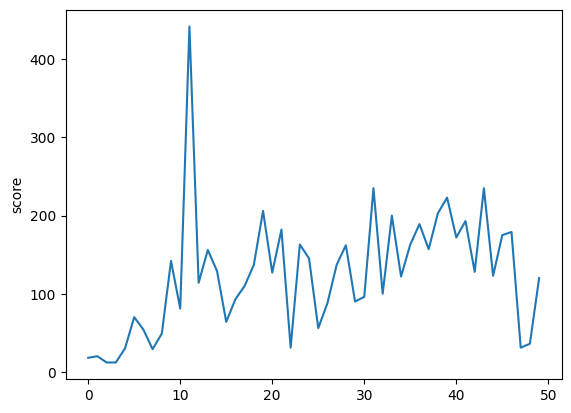

In [24]:
# 점수 시각화
plt.plot(score_history)
plt.ylabel('score')
plt.show()